## 1. Problem Statement

In the digital age, users are overwhelmed by vast movie options on streaming platforms, making it difficult to discover relevant content. Traditional recommendation methods fall short in addressing unique user preferences and the cold-start problem. This project aims to develop a content-based filtering recommender system using a neural network to leverage movie features like genres and titles. The goal is to provide personalized movie recommendations for both new and existing users and to identify similar movies, enhancing user satisfaction and engagement.

## 2. Importing Packages

In [2]:
# Import necessary packages
import numpy as np
import numpy.ma as ma
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tabulate
from recsysNN_utils import *
pd.set_option("display.precision", 1)

## 2. Dataset

The necessary data on movie ratings was derived from the [MovieLens ml-latest-small](https://grouplens.org/datasets/movielens/latest/) dataset. For each movie, the dataset provides a movie title, release date, and one or more genres. 
The table below shows the top 10 movies ranked by the number of ratings.

In [3]:
top10_df = pd.read_csv("./data/content_top10_df.csv")
bygenre_df = pd.read_csv("./data/content_bygenre_df.csv")
top10_df

,movie id,num ratings,ave rating,title,genres
0,4993,198,4.1,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
1,5952,188,4.0,"Lord of the Rings: The Two Towers, The",Adventure|Fantasy
2,7153,185,4.1,"Lord of the Rings: The Return of the King, The",Action|Adventure|Drama|Fantasy
3,4306,170,3.9,Shrek,Adventure|Animation|Children|Comedy|Fantasy|Ro...
4,58559,149,4.2,"Dark Knight, The",Action|Crime|Drama
5,6539,149,3.8,Pirates of the Caribbean: The Curse of the Bla...,Action|Adventure|Comedy|Fantasy
6,79132,143,4.1,Inception,Action|Crime|Drama|Mystery|Sci-Fi|Thriller
7,6377,141,4.0,Finding Nemo,Adventure|Animation|Children|Comedy
8,4886,132,3.9,"Monsters, Inc.",Adventure|Animation|Children|Comedy|Fantasy
9,7361,131,4.2,Eternal Sunshine of the Spotless Mind,Drama|Romance|Sci-Fi


The next table shows information sorted by genre.

In [4]:
bygenre_df

,genre,num movies,ave rating/genre,ratings per genre
0,Action,321,3.4,10377
1,Adventure,234,3.4,8785
2,Animation,76,3.6,2588
3,Children,69,3.4,2472
4,Comedy,326,3.4,8911
5,Crime,139,3.5,4671
6,Documentary,13,3.8,280
7,Drama,342,3.6,10201
8,Fantasy,124,3.4,4468
9,Horror,56,3.2,1345


## 3. Preparing Training Data

The training set is split into two arrays with the same number of entries, a user array and a movie/item array.  

In [5]:
# Load Data, set configuration variables
item_train, user_train, y_train, item_features, user_features, item_vecs, movie_dict, user_to_genre = load_data()

num_user_features = user_train.shape[1] - 3  # remove userid, rating count and ave rating during training
num_item_features = item_train.shape[1] - 1  # remove movie id at train time
uvs = 3  # user genre vector start
ivs = 3  # item genre vector start
u_s = 3  # start of columns to use in training, user
i_s = 1  # start of columns to use in training, items
print(f"Number of training vectors: {len(item_train)}")

Number of training vectors: 50884


In [6]:
pprint_train(user_train, user_features, uvs,  u_s, maxcount=5)

[user id],[rating count],[rating ave],Act ion,Adve nture,Anim ation,Chil dren,Com edy,Crime,Docum entary,Drama,Fan tasy,Hor ror,Mys tery,Rom ance,Sci -Fi,Thri ller
2,22,4.0,4.0,4.2,0.0,0.0,4.0,4.1,4.0,4.0,0.0,3.0,4.0,0.0,3.9,3.9
2,22,4.0,4.0,4.2,0.0,0.0,4.0,4.1,4.0,4.0,0.0,3.0,4.0,0.0,3.9,3.9
2,22,4.0,4.0,4.2,0.0,0.0,4.0,4.1,4.0,4.0,0.0,3.0,4.0,0.0,3.9,3.9
2,22,4.0,4.0,4.2,0.0,0.0,4.0,4.1,4.0,4.0,0.0,3.0,4.0,0.0,3.9,3.9
2,22,4.0,4.0,4.2,0.0,0.0,4.0,4.1,4.0,4.0,0.0,3.0,4.0,0.0,3.9,3.9


In [7]:
pprint_train(item_train, item_features, ivs, i_s, maxcount=5, user=False)

[movie id],year,ave rating,Act ion,Adve nture,Anim ation,Chil dren,Com edy,Crime,Docum entary,Drama,Fan tasy,Hor ror,Mys tery,Rom ance,Sci -Fi,Thri ller
6874,2003,4.0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
8798,2004,3.8,1,0,0,0,0,1,0,1,0,0,0,0,0,1
46970,2006,3.2,1,0,0,0,1,0,0,0,0,0,0,0,0,0
48516,2006,4.3,0,0,0,0,0,1,0,1,0,0,0,0,0,1
58559,2008,4.2,1,0,0,0,0,1,0,1,0,0,0,0,0,0


In [8]:
print(f"y_train[:5]: {y_train[:5]}")

y_train[:5]: [4.  3.5 4.  4.  4.5]


Now, we scale the input features using the scikit learn StandardScaler. 
We scale the target ratings using a Min Max Scaler which scales the target to be between -1 and 1. 

In [9]:
# scale training data
item_train_unscaled = item_train
user_train_unscaled = user_train
y_train_unscaled    = y_train

scalerItem = StandardScaler()
scalerItem.fit(item_train)
item_train = scalerItem.transform(item_train)

scalerUser = StandardScaler()
scalerUser.fit(user_train)
user_train = scalerUser.transform(user_train)

scalerTarget = MinMaxScaler((-1, 1))
scalerTarget.fit(y_train.reshape(-1, 1))
y_train = scalerTarget.transform(y_train.reshape(-1, 1))
#ynorm_test = scalerTarget.transform(y_test.reshape(-1, 1))

print(np.allclose(item_train_unscaled, scalerItem.inverse_transform(item_train)))
print(np.allclose(user_train_unscaled, scalerUser.inverse_transform(user_train)))

True
True


In order to evaluate the results later, we will split the data into training and test sets.

In [10]:
item_train, item_test = train_test_split(item_train, train_size=0.80, shuffle=True, random_state=1)
user_train, user_test = train_test_split(user_train, train_size=0.80, shuffle=True, random_state=1)
y_train, y_test       = train_test_split(y_train,    train_size=0.80, shuffle=True, random_state=1)
print(f"movie/item training data shape: {item_train.shape}")
print(f"movie/item test data shape: {item_test.shape}")

movie/item training data shape: (40707, 17)
movie/item test data shape: (10177, 17)


In [11]:
pprint_train(user_train, user_features, uvs, u_s, maxcount=5)

[user id],[rating count],[rating ave],Act ion,Adve nture,Anim ation,Chil dren,Com edy,Crime,Docum entary,Drama,Fan tasy,Hor ror,Mys tery,Rom ance,Sci -Fi,Thri ller
1,0,-1.0,-0.8,-0.7,0.1,-0.0,-1.2,-0.4,0.6,-0.5,-0.5,-0.1,-0.6,-0.6,-0.7,-0.7
0,1,-0.7,-0.5,-0.7,-0.1,-0.2,-0.6,-0.2,0.7,-0.5,-0.8,0.1,-0.0,-0.6,-0.5,-0.4
-1,-1,-0.2,0.3,-0.4,0.4,0.5,1.0,0.6,-1.2,-0.3,-0.6,-2.3,-0.1,0.0,0.4,-0.0
0,-1,0.6,0.5,0.5,0.2,0.6,-0.1,0.5,-1.2,0.9,1.2,-2.3,-0.1,0.0,0.2,0.3
-1,0,0.7,0.6,0.5,0.3,0.5,0.4,0.6,1.0,0.6,0.3,0.8,0.8,0.4,0.7,0.7


## 4. Construct Neural Network

We generate two vectors, a user vector and an item/movie vector whose dot product would predict a rating. In order to generate the vectors, the ratings along with additional information about the user and/or movie that may improve the prediction is provided to a neural network.
Now, let's construct a neural network  for content-based filtering. It will have two networks that are combined by a dot product as shown in the figure.

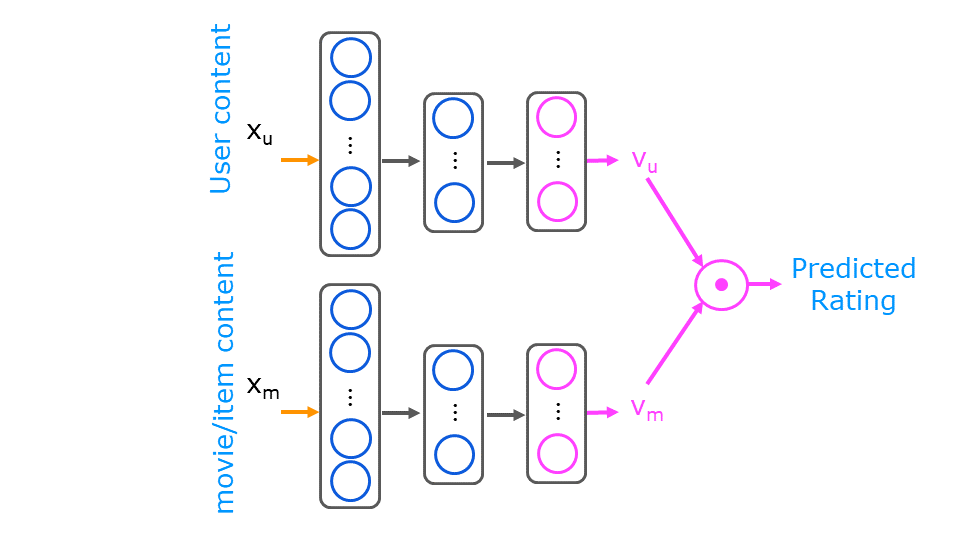

Let's use a Keras sequential model. The first layer is a dense layer with 256 units and a relu activation. The second layer is a dense layer with 128 units and a relu activation. The third layer is a dense layer with `num_outputs` units and a linear or no activation.   

In [12]:
num_outputs = 32
tf.random.set_seed(1)

# first layer
user_NN = tf.keras.models.Sequential([    
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs),
])
item_NN = tf.keras.models.Sequential([  
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs),
])


input_user = tf.keras.layers.Input(shape=(num_user_features))
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)

input_item = tf.keras.layers.Input(shape=(num_item_features))
vm = item_NN(input_item)
vm = tf.linalg.l2_normalize(vm, axis=1)

# dot product of the vectors vu and vm
output = tf.keras.layers.Dot(axes=1)([vu, vm])

# inputs and output of the model
model = tf.keras.Model([input_user, input_item], output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 14)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 32)           40864       input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 32)           41376       input_2[0][0]                    
______________________________________________________________________________________________

We will use a mean squared error loss and an Adam optimizer.

In [13]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss=cost_fn)

In [14]:
tf.random.set_seed(1)
model.fit([user_train[:, u_s:], item_train[:, i_s:]], y_train, epochs=30)

Train on 40707 samples
Epoch 1/30
40707/40707 [==============================] - 5s 125us/sample - loss: 0.1232
Epoch 2/30
40707/40707 [==============================] - 5s 113us/sample - loss: 0.1146
Epoch 3/30
40707/40707 [==============================] - 5s 115us/sample - loss: 0.1089
Epoch 4/30
40707/40707 [==============================] - 5s 113us/sample - loss: 0.1039
Epoch 5/30
40707/40707 [==============================] - 5s 113us/sample - loss: 0.1001
Epoch 6/30
40707/40707 [==============================] - 5s 115us/sample - loss: 0.0973
Epoch 7/30
40707/40707 [==============================] - 5s 113us/sample - loss: 0.0956
Epoch 8/30
40707/40707 [==============================] - 5s 113us/sample - loss: 0.0935
Epoch 9/30
40707/40707 [==============================] - 5s 113us/sample - loss: 0.0916
Epoch 10/30
40707/40707 [==============================] - 5s 113us/sample - loss: 0.0897
Epoch 11/30
40707/40707 [==============================] - 5s 115us/sample - loss: 0.0

Evaluate the model.

In [ ]:
model.evaluate([user_test[:, u_s:], item_test[:, i_s:]], y_test)

## 5 Predictions for a new user

Let's create a new user and have the model suggest movies for that user.

In [ ]:
new_user_id = 5000
new_rating_ave = 0.0
new_action = 0.0
new_adventure = 5.0
new_animation = 0.0
new_childrens = 0.0
new_comedy = 0.0
new_crime = 0.0
new_documentary = 0.0
new_drama = 0.0
new_fantasy = 5.0
new_horror = 0.0
new_mystery = 0.0
new_romance = 0.0
new_scifi = 0.0
new_thriller = 0.0
new_rating_count = 3

user_vec = np.array([[new_user_id, new_rating_count, new_rating_ave,
                      new_action, new_adventure, new_animation, new_childrens,
                      new_comedy, new_crime, new_documentary,
                      new_drama, new_fantasy, new_horror, new_mystery,
                      new_romance, new_scifi, new_thriller]])

In [ ]:
user_vecs = gen_user_vecs(user_vec,len(item_vecs))
# scale
suser_vecs = scalerUser.transform(user_vecs)
sitem_vecs = scalerItem.transform(item_vecs)

# make prediction
y_p = model.predict([suser_vecs[:, u_s:], sitem_vecs[:, i_s:]])

# unscale y prediction 
y_pu = scalerTarget.inverse_transform(y_p)

# sort the results
sorted_index = np.argsort(-y_pu,axis=0).reshape(-1).tolist()  #negate to get largest rating first
sorted_ypu   = y_pu[sorted_index]
sorted_items = item_vecs[sorted_index]  #using unscaled vectors for display

print_pred_movies(sorted_ypu, sorted_items, movie_dict, maxcount = 10)

## 6. Predictions for an existing user.
Let's predict for "user 2", from the data set.

In [ ]:
uid = 2 
user_vecs, y_vecs = get_user_vecs(uid, user_train_unscaled, item_vecs, user_to_genre)

# scale
suser_vecs = scalerUser.transform(user_vecs)
sitem_vecs = scalerItem.transform(item_vecs)

# make prediction
y_p = model.predict([suser_vecs[:, u_s:], sitem_vecs[:, i_s:]])

# unscale y prediction 
y_pu = scalerTarget.inverse_transform(y_p)

# sort the results
sorted_index = np.argsort(-y_pu,axis=0).reshape(-1).tolist()  #negate to get largest rating first
sorted_ypu   = y_pu[sorted_index]
sorted_items = item_vecs[sorted_index]  #using unscaled vectors for display
sorted_user  = user_vecs[sorted_index]
sorted_y     = y_vecs[sorted_index]

print_existing_user(sorted_ypu, sorted_y.reshape(-1,1), sorted_user, sorted_items, ivs, uvs, movie_dict, maxcount = 50)

<a name="5.3"></a>
### 7. Recommending Similar Movies

A similarity measure between two movie vectors $ \mathbf{v_m^{(k)}}$ and $\mathbf{v_m^{(i)}}$ is given by the squared distance between the two vectors:
$$\left\Vert \mathbf{v_m^{(k)}} - \mathbf{v_m^{(i)}}  \right\Vert^2 = \sum_{l=1}^{n}(v_{m_l}^{(k)} - v_{m_l}^{(i)})^2\tag{1}$$

In [ ]:
def sq_dist(a,b):     
    d = np.sum(np.square(a-b))   
    return (d)

Now we compute a matrix of squared distances between each movie feature vector with all other movie feature vectors. This matrix is later reused for new recommendations.
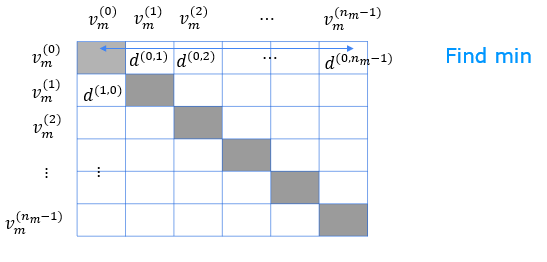

In [ ]:
input_item_m = tf.keras.layers.Input(shape=(num_item_features))    # input layer
vm_m = item_NN(input_item_m)                                       # use the trained item_NN
vm_m = tf.linalg.l2_normalize(vm_m, axis=1)                        # incorporate normalization as was done in the original model
model_m = tf.keras.Model(input_item_m, vm_m)                                
model_m.summary()

In [ ]:
scaled_item_vecs = scalerItem.transform(item_vecs)
vms = model_m.predict(scaled_item_vecs[:,i_s:])
print(f"size of all predicted movie feature vectors: {vms.shape}")

The movie to be recommended is found by computing the minimum along each row.

In [ ]:
count = 50  # number of movies to display
dim = len(vms)
dist = np.zeros((dim,dim))

for i in range(dim):
    for j in range(dim):
        dist[i,j] = sq_dist(vms[i, :], vms[j, :])
        
m_dist = ma.masked_array(dist, mask=np.identity(dist.shape[0]))  # mask the diagonal

disp = [["movie1", "genres", "movie2", "genres"]]
for i in range(count):
    min_idx = np.argmin(m_dist[i])
    movie1_id = int(item_vecs[i,0])
    movie2_id = int(item_vecs[min_idx,0])
    disp.append( [movie_dict[movie1_id]['title'], movie_dict[movie1_id]['genres'],
                  movie_dict[movie2_id]['title'], movie_dict[movie1_id]['genres']]
               )
table = tabulate.tabulate(disp, tablefmt='html', headers="firstrow")
table

Therefore, the results show that the model generally suggests a movie with similar genre.